In [1]:
from model_utils import configuration as cnf
from plotting import model_plots
from plotting import data_plots
from model_utils import initialisation as init
import sectors
import pyomo.environ as pyo

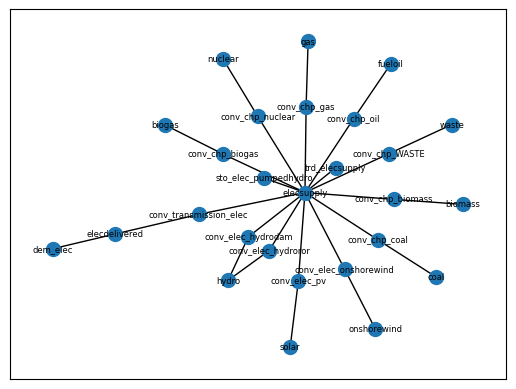

In [2]:
# Show network complexity
data_plots.plot_io_network(cnf.DATA)

In [4]:
# Model setup
model = init.init_model()

# sectors.trade.configure_sector(model)
sectors.extraction.configure_sector(model)
# sectors.storage.configure_sector(model)

# sectors.electricity.configure_sector(model)
# sectors.transmission.configure_sector(model)
# # sectors.passenger.configure_sector(model)

# sectors.demands.configure_sector(model)

ERROR: Rule failed for Expression 'e_CostInv' with index conv_chp_coal:
    TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'
ERROR: Constructing component 'e_CostInv' from data=None failed: TypeError:
    unsupported operand type(s) for *: 'float' and 'NoneType'


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
model.e_HourlyC2A.pprint()

In [ ]:
import model_utils.generic_constraints as gen

In [ ]:

model.condser = pyo.Constraint(model.N, ["conv_chp_WASTE"], model.Y, rule=gen.c_act_cf_max_year)
model.condser.pprint()

In [ ]:
# Investment cost
def e_costinv_p_y(model, process, year):
    if process in model.Caps:
        cost_inv = cnf.DATA.get(process, "cost_investment", year)
        return model.DISCRATE[year]*cost_inv*model.cnew[process,year]
    return pyo.Expression.Skip

def e_costinv_y(model, year):
    return sum(model.e_costinv_p_y[p, y] for p,y in model.e_costinv_p_y if y == year)

def e_costinv(model):
    return sum(model.e_costinv_y[y] for y in model.e_costinv_y)

model.e_costinv_p_y = pyo.Expression(model.Pros, model.Years, rule=e_costinv_p_y)
model.e_costinv_y = pyo.Expression(model.Years, rule=e_costinv_y)
model.e_costinv = pyo.Expression(rule=e_costinv)

In [ ]:

def e_costfixedom_p_y(model, process, year):
    if process in model.Caps:
        cost_fom = cnf.DATA.get(process, "cost_fixed_om_annual", year)
        return model.DISCRATE[year]*cost_fom*model.ctot[process,year]
    return pyo.Expression.Skip

def e_costfixedom_y(model, year):
    return sum(model.e_costfixedom_p_y[p, y] for p,y in model.e_costfixedom_p_y if y == year)

def e_costfixedom(model):
    return sum(model.e_costfixedom_y[y] for y in model.e_costfixedom_y)

model.e_costfixedom_p_y = pyo.Expression(model.Pros, model.Years, rule=e_costfixedom_p_y)
model.e_costfixedom_y = pyo.Expression(model.Years, rule=e_costfixedom_y)
model.e_costfixedom = pyo.Expression(rule=e_costfixedom)

In [ ]:
def e_costvar_p_y_h(model, process, year, hour):
    # Variable cost is type-dependent to improve readability at the database-level.
    d_f = model.DISCRATE[year]
    cost = 0
    if process in model.Trades:
        if process not in model.TradesImp:
            return pyo.Expression.Skip
        cost_var = cnf.DATA.get(process, "cost_import", year)
        cost = d_f*cost_var*model.aimp[process, year, hour]
    else:
        cost_var = cnf.DATA.get(process, "cost_variable_om", year)
        cost = d_f*cost_var*model.a[process, year, hour]
    return cost if not isinstance(cost, (int, float)) else pyo.Expression.Skip

def e_costvar_y(model, year):
    return model.TPERIOD * sum(model.e_costvar_p_y_h[p,y,h] for p,y,h in model.e_costvar_p_y_h if y == year)

def e_costvar(model):
    return sum(model.e_costvar_y[y] for y in model.e_costvar_y)

model.e_costvar_p_y_h = pyo.Expression(model.Pros, model.Years, model.Hours, rule=e_costvar_p_y_h)
model.e_costvar_y = pyo.Expression(model.Years, rule=e_costvar_y)
model.e_costvar = pyo.Expression(rule=e_costvar)

In [ ]:
def e_revenuevar_p_y_h(model, process, year, hour):
    # Variable cost is type-dependent to improve readability at the database-level.
    if process in model.TradesExp:
        discount_f = model.DISCRATE[year]
        rev_var = cnf.DATA.get(process, "revenue_export", year)
        return discount_f*rev_var*model.aexp[process, year, hour]
    return pyo.Expression.Skip

def e_revenuevar_y(model, year):
    return model.TPERIOD * sum(model.e_revenuevar_p_y_h[p,y,h] for p,y,h in model.e_revenuevar_p_y_h if y == year)

def e_revenuevar(model):
    return sum(model.e_revenuevar_y[y] for y in model.e_revenuevar_y)

model.e_revenuevar_p_y_h = pyo.Expression(model.Pros, model.Years, model.Hours, rule=e_revenuevar_p_y_h)
model.e_revenuevar_y = pyo.Expression(model.Years, rule=e_revenuevar_y)
model.e_revenuevar = pyo.Expression(rule=e_revenuevar)

In [ ]:
tot_cost_expr = model.e_costinv + model.e_costfixedom + model.e_costvar - model.e_revenuevar
model.cost = pyo.Objective(expr=tot_cost_expr, sense=pyo.minimize)
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

opt = pyo.SolverFactory("gurobi", solver_io="python")
opt.options["MIPGap"] = 1e-2
opt.options["Timelimit"] = 1800
try:
    opt_result = opt.solve(model, tee=False)
    print(opt_result)
except ValueError:
    model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})

# Plotting

In [ ]:
model_plots.plot_flow_fin(model, cnf.DATA, ["elecsupply"], unit="TWh")

In [ ]:
model_plots.plot_flow_fout(model, cnf.DATA, ["elecsupply"], unit="TWh", hist="elecsupply")

In [ ]:
data_plots.plot_flow_fout(model, cnf.DATA, ["elecsupply"], unit="Mpkm")

In [ ]:
model_plots.plot_group_ctot(model, ["_chp_", "elec_"], "GW")

In [ ]:
data_plots.plot_group_ctot(model, cnf.DATA, ["_chp_", "elec_"], "GW")

In [ ]:
model.trd_c_cap_transfer.pprint()

# Debug
Check your model run :)

In [ ]:
for y in model.Years:
    for h in model.Hours:
        tech = "sto_elec_pumpedhydro"
        flow = "elecsupply"
        print(f"", "fin", model.fin[flow, tech, y, h].value, "soc", model.a[tech, y, h].value, "fout", model.fout[flow, tech, y, h].value)

In [ ]:
from pyomo.util import infeasible
infeasible.log_infeasible_constraints(model, log_expression=True, log_variables=True)
infeasible.log_infeasible_bounds(model)
# infeasible.log_close_to_bounds(model)

In [ ]:
import gurobi

model.write("debug.lp", format="lp", io_options={"symbolic_solver_labels": True})
m = gurobi.read("debug.lp")
m.optimize()
m.computeIIS()
m.write("debug_{0}.ilp".format("CHE"))